Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix ,classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Fiverr/price_pred_amal.csv")

In [ ]:
df.head(7)

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel
5,202009304412074,16000.0,17,Blue,Audi,S5,USED,2017.0,29000,Convertible,False,Petrol
6,202007080998445,24075.0,17,Red,Vauxhall,Viva,USED,2017.0,5861,Hatchback,False,Petrol


In [ ]:
df.tail(3)

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
402002,202010315659271,52760.0,62,White,Nissan,Qashqai,USED,2012.0,7250,SUV,False,Petrol
402003,202011015662436,10250.0,65,Red,Abarth,595,USED,2015.0,11490,Hatchback,False,Petrol
402004,201512149444029,14000.0,14,Silver,Audi,A4 Avant,USED,2014.0,20520,Estate,False,Diesel


In [ ]:
print(df.shape)
df.columns

(402005, 12)


Index(['public_reference', 'mileage', 'reg_code', 'standard_colour',
       'standard_make', 'standard_model', 'vehicle_condition',
       'year_of_registration', 'price', 'body_type', 'crossover_car_and_van',
       'fuel_type'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [ ]:
df.duplicated().sum()   # looking for duplicate rows

0

In [ ]:
df.isnull().sum()   # looking for null values

public_reference             0
mileage                    127
reg_code                 31857
standard_colour           5378
standard_make                0
standard_model               0
vehicle_condition            0
year_of_registration     33311
price                        0
body_type                  837
crossover_car_and_van        0
fuel_type                  601
dtype: int64

Data Preprocessing

In [ ]:
df = df.drop(columns=['public_reference'])

In [ ]:
df['crossover_car_and_van'] = df['crossover_car_and_van'].astype(int)     # convert bool type column into Integer

In [ ]:
df['reg_code'] = pd.to_numeric(df['reg_code'], errors='coerce')

In [ ]:
columns_with_missing = ['mileage', 'reg_code', 'standard_colour', 'year_of_registration', 'body_type', 'fuel_type']

In [ ]:
df['mileage'].fillna(df['mileage'].mean(), inplace=True)

imputer = SimpleImputer(strategy='most_frequent')
for col in ['standard_colour', 'body_type', 'fuel_type']:
    df[col] = imputer.fit_transform(df[[col]]).ravel()

df.dropna(subset=['reg_code', 'year_of_registration'], inplace=True)

# reset index
df.reset_index(drop=True, inplace=True)

In [ ]:
# find the columns with outliers value
numerical_columns = df.select_dtypes(include=[np.number])

columns_with_outliers = []

for column in numerical_columns.columns:
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    threshold = 5

    if any(z_scores > threshold):
        columns_with_outliers.append(column)

print("Columns with outliers:", columns_with_outliers)

Columns with outliers: ['mileage', 'year_of_registration', 'price', 'crossover_car_and_van']


In [ ]:
# removing the outiers

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

columns_with_outliers = ['mileage', 'year_of_registration', 'price', 'crossover_car_and_van']
for column in columns_with_outliers:
    df = remove_outliers_iqr(df, column)

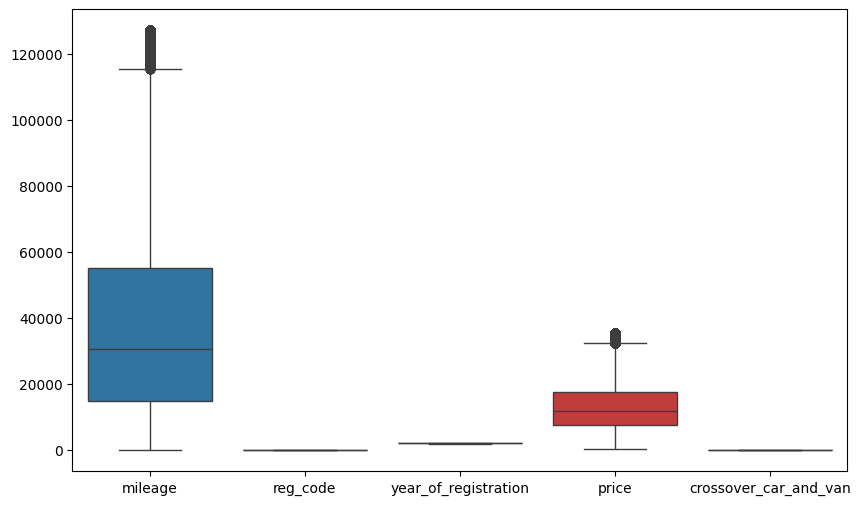

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df, orient='v')
plt.show()

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mileage,319303.0,37536.589383,28721.190156,0.0,14800.0,30651.0,55000.0,127069.0
reg_code,319303.0,40.881555,25.062556,2.0,17.0,58.0,66.0,70.0
year_of_registration,319303.0,2015.738953,2.975103,2008.0,2014.0,2016.0,2018.0,2020.0
price,319303.0,13187.208670,7396.589169,250.0,7551.0,11850.0,17495.0,35526.0
crossover_car_and_van,319303.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


<Axes: >

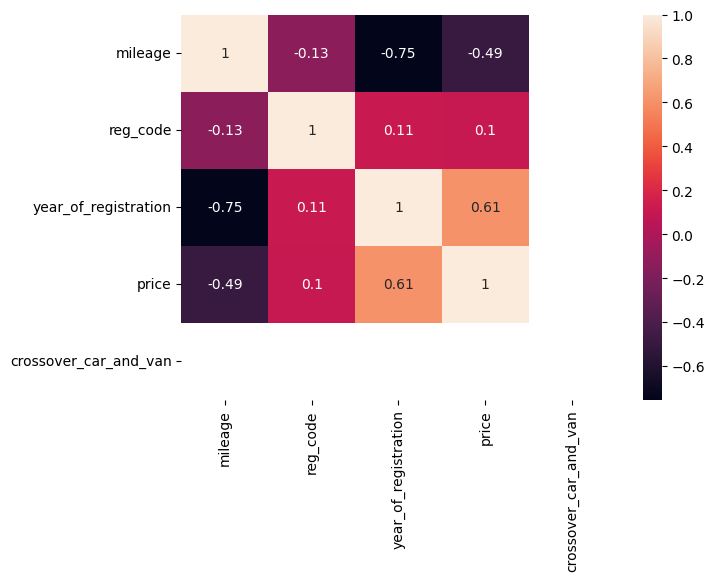

In [ ]:
plt.figure(figsize=(7, 5))

# only numerical columns
num_col = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(num_col.corr(), annot=True, cmap='rocket')

In [ ]:
#Feature Engineering
current_year = 2024
df['car_age'] = current_year - df['year_of_registration']

df['avg_annual_mileage'] = df['mileage'] / df['car_age']

df['mileage_squared'] = df['mileage'] ** 2
df['year_of_registration_squared'] = df['year_of_registration'] ** 2

df['mileage_year_interaction'] = df['mileage'] * df['year_of_registration']

In [ ]:
df.head(3)

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,car_age,avg_annual_mileage,mileage_squared,year_of_registration_squared,mileage_year_interaction
0,108230.0,61.0,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,0,Diesel,13.0,8325.384615,1.171373e+10,4044121.0,217650530.0
1,7800.0,17.0,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,0,Petrol,7.0,1114.285714,6.084000e+07,4068289.0,15732600.0
2,45000.0,16.0,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,0,Diesel,8.0,5625.000000,2.025000e+09,4064256.0,90720000.0


In [ ]:
print(df.shape)
df.columns

(319303, 16)


Index(['mileage', 'reg_code', 'standard_colour', 'standard_make',
       'standard_model', 'vehicle_condition', 'year_of_registration', 'price',
       'body_type', 'crossover_car_and_van', 'fuel_type', 'car_age',
       'avg_annual_mileage', 'mileage_squared', 'year_of_registration_squared',
       'mileage_year_interaction'],
      dtype='object')

In [ ]:
df_1 = df.copy()    # copy the dataset in a new variable

In [ ]:
# Label Encoding
df_1['standard_colour'] = label.fit_transform(df_1['standard_colour'])    #transfrom the strings in numeric values

df_1['standard_make'] = label.fit_transform(df_1['standard_make'])

df_1['standard_model'] = label.fit_transform(df_1['standard_model'])

df_1['vehicle_condition'] = label.fit_transform(df_1['vehicle_condition'])

df_1['body_type'] = label.fit_transform(df_1['body_type'])

df_1['fuel_type'] = label.fit_transform(df_1['fuel_type'])

In [ ]:
x = df_1.drop('price', axis=1)
y = df_1['price']
y

0          7000
1         14000
2          7995
3         26995
4         29000
          ...  
365537    10595
365538     2000
365539     7250
365540    11490
365541    20520
Name: price, Length: 319303, dtype: int64

In [ ]:
# feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
X_scaled = scaler.transform(x)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 42)   # split the dataset

In [ ]:
# feature selection
from sklearn.feature_selection import SelectFromModel

# SelectFromModel with RandomForestRegressor as base estimator
selector = SelectFromModel(RandomForestRegressor(n_estimators=50, random_state=42))
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [ ]:
print("Original Feature Space:", X_train.shape)
print("Selected Feature Space:", X_train_selected.shape)


Original Feature Space: (239477, 15)
Selected Feature Space: (239477, 6)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

feature_names = ['mileage', 'reg_code', 'standard_colour', 'standard_make',
       'standard_model', 'vehicle_condition', 'year_of_registration', 'price',
       'body_type', 'crossover_car_and_van', 'fuel_type', 'car_age',
       'avg_annual_mileage', 'mileage_squared', 'year_of_registration_squared',
       'mileage_year_interaction']

rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Get total sum of feature importance scores
total_importance = sum(feature_importances)

# Print feature importance scores in percentage
for feature_name, importance_score in zip(feature_names, feature_importances):
    importance_percentage = (importance_score / total_importance) * 100
    print(f"{feature_name}: {importance_percentage:.2f}%")


mileage: 1.89%
reg_code: 0.97%
standard_colour: 1.03%
standard_make: 19.54%
standard_model: 14.14%
vehicle_condition: 0.00%
year_of_registration: 16.03%
price: 13.02%
body_type: 0.00%
crossover_car_and_van: 4.61%
fuel_type: 9.58%
car_age: 1.47%
avg_annual_mileage: 1.90%
mileage_squared: 13.86%
year_of_registration_squared: 1.98%


Model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Boosted Tree': GradientBoostingRegressor(random_state=42)
}

Model: Linear Regression
Mean Squared Error (CV): 28499408.411795795
Mean Squared Error: 28533866.449986838
Mean Absolute Error: 4031.066290407104
R^2 Score: 0.4790520399816305


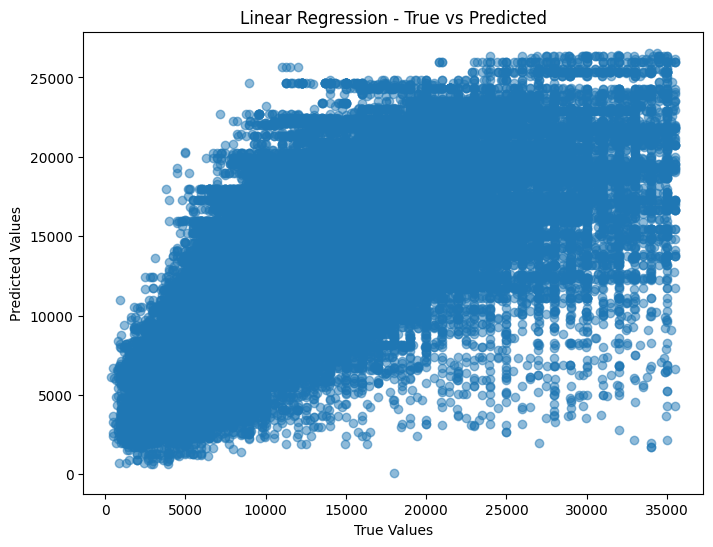

Model: Random Forest
Mean Squared Error (CV): 5237726.067993097
Mean Squared Error: 5303662.6986718755
Mean Absolute Error: 1600.06764900355
R^2 Score: 0.9031700709631691


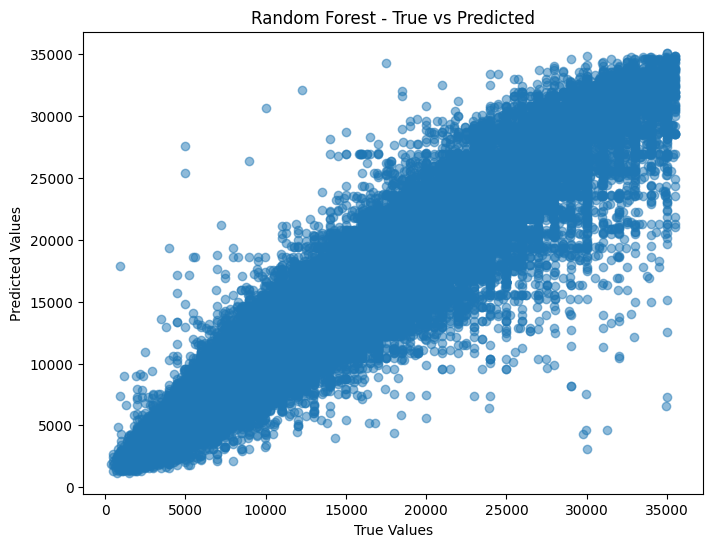

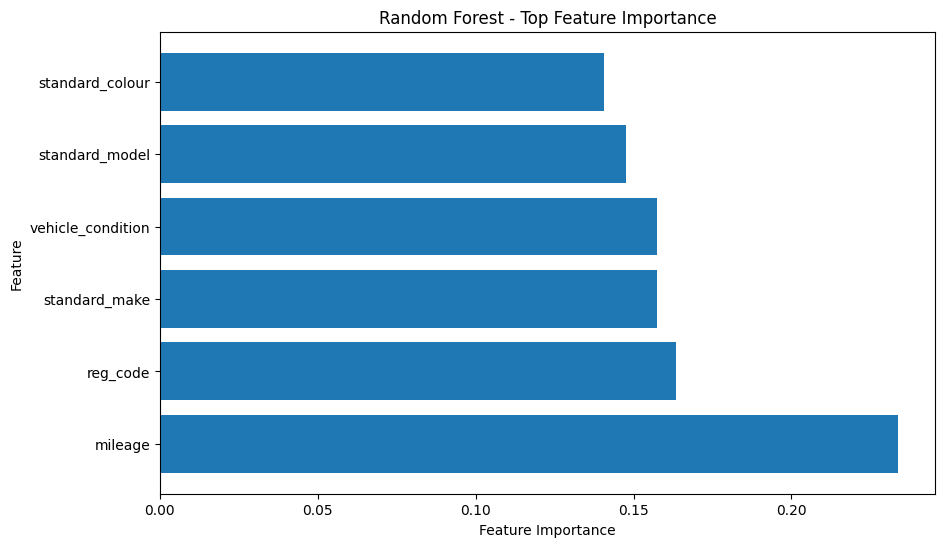

Model: Boosted Tree
Mean Squared Error (CV): 12994308.965789275
Mean Squared Error: 12887525.473739374
Mean Absolute Error: 2559.831389119171
R^2 Score: 0.7647101167660931


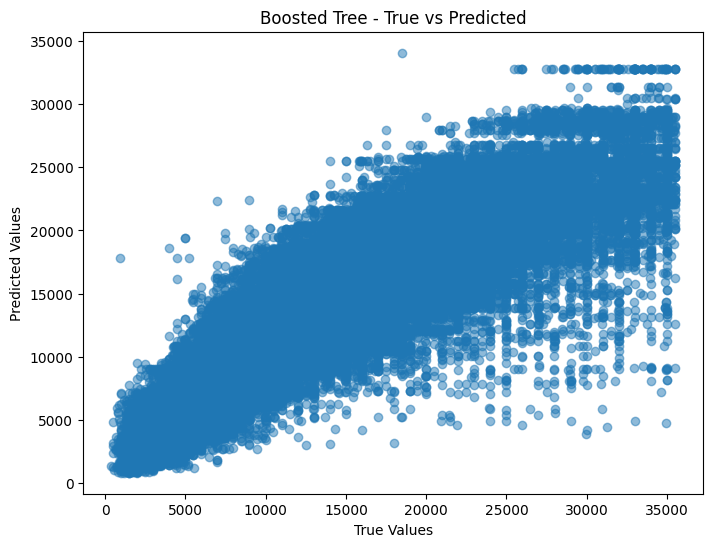

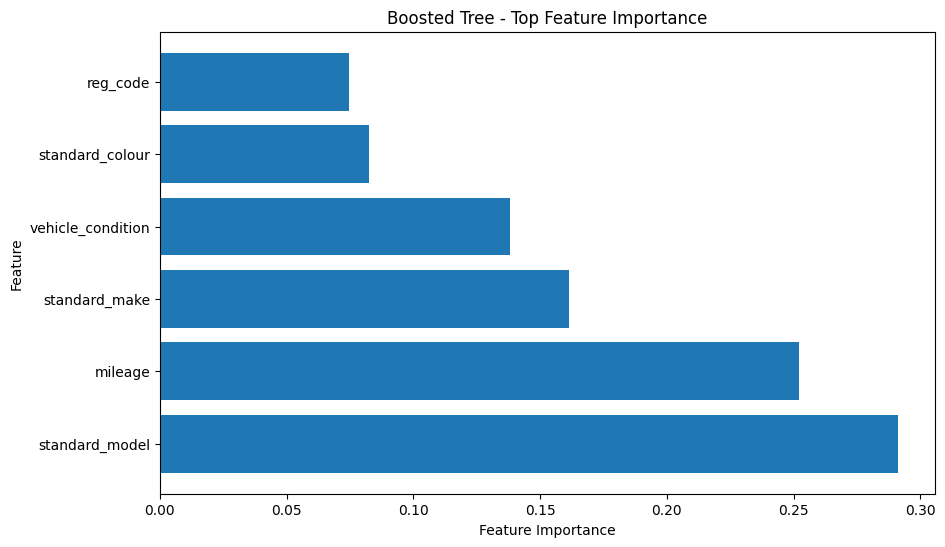

In [ ]:
for name, model in models.items():
    # hyperparameter tuning using GridSearchCV
    if name == 'Linear Regression':
        params = {}
        best_model = model
    else:
        param_grid = {}

        # GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
        grid_search.fit(X_train_selected, y_train)
        best_model = grid_search.best_estimator_

    # model using cross-validation
    cv_scores = cross_val_score(best_model, X_train_selected, y_train, scoring='neg_mean_squared_error', cv=5)
    mse_mean = -cv_scores.mean()

    # fit the best model to the training data
    best_model.fit(X_train_selected, y_train)

    # predictions on the testing data
    y_pred = best_model.predict(X_test_selected)

    # evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # print evaluation metrics
    print(f"Model: {name}")
    print(f"Mean Squared Error (CV): {mse_mean}")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")

    # true vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} - True vs Predicted")
    plt.show()

    # feature importance for tree-based models
    column_names = ['mileage', 'reg_code', 'standard_colour', 'standard_make',
       'standard_model', 'vehicle_condition', 'year_of_registration',
       'body_type', 'crossover_car_and_van', 'fuel_type', 'car_age',
       'avg_annual_mileage', 'mileage_squared', 'year_of_registration_squared',
       'mileage_year_interaction']

    # convert X_train to a DataFrame
    X_train_df = pd.DataFrame(X_train, columns=column_names)

    original_columns = X_train_df.columns
    if name in ['Random Forest', 'Boosted Tree']:
        feature_importance = best_model.feature_importances_
        sorted_idx = np.argsort(feature_importance)[::-1]
        top_features = original_columns[sorted_idx][:10]  # using original column names
        plt.figure(figsize=(10, 6))
        plt.barh(top_features, feature_importance[sorted_idx][:10])
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title(f"{name} - Top Feature Importance")
        plt.show()


In [ ]:
from collections import Counter

# Calculate the count of each unique pair of true and predicted values
true_predicted_counts = Counter(zip(y_test, y_pred))

# Print the counts
for true, pred in true_predicted_counts:
    print(f"True Value: {true}, Predicted Value: {pred}, Count: {true_predicted_counts[(true, pred)]}")


Streaming output truncated to the last 5000 lines.
True Value: 11495, Predicted Value: 10267.63714465147, Count: 1
True Value: 18690, Predicted Value: 19660.397206337344, Count: 1
True Value: 9990, Predicted Value: 12234.854692997698, Count: 1
True Value: 5750, Predicted Value: 8277.258121484281, Count: 1
True Value: 10590, Predicted Value: 10267.63714465147, Count: 1
True Value: 3700, Predicted Value: 3787.744841682984, Count: 1
True Value: 5295, Predicted Value: 6768.003578490449, Count: 1
True Value: 8580, Predicted Value: 10053.260124417104, Count: 1
True Value: 10895, Predicted Value: 13623.741069314186, Count: 1
True Value: 7595, Predicted Value: 8935.719537702093, Count: 1
True Value: 17000, Predicted Value: 18519.007782778182, Count: 1
True Value: 33490, Predicted Value: 9289.484911513679, Count: 1
True Value: 18995, Predicted Value: 15898.426261017445, Count: 1
True Value: 7150, Predicted Value: 13167.584554989278, Count: 1
True Value: 10500, Predicted Value: 14757.49159312425

In [ ]:
# training accuracy
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_train_pred = model.predict(X_train_selected)
    r2_train = r2_score(y_train, y_train_pred)

    print(f"Model: {name}")
    print(f"Training R^2 Score: {r2_train}")


Model: Linear Regression
Training R^2 Score: 0.478897968138183
Model: Random Forest
Training R^2 Score: 0.9098186124191088
Model: Boosted Tree
Training R^2 Score: 0.7663232479844991


Voting Ensemble Model:
Mean Squared Error: 7137438.9393292945
Mean Absolute Error: 1913.3889676952836
R^2 Score: 0.869690486506045


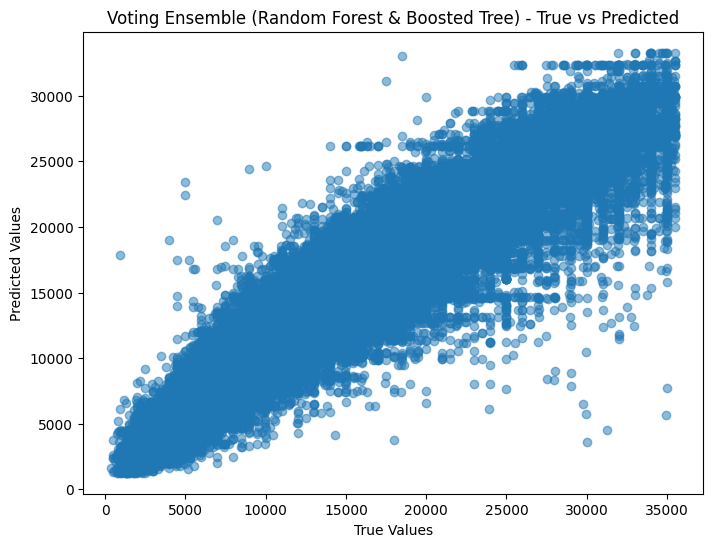

In [ ]:
# ensemble
from sklearn.ensemble import VotingRegressor

models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Boosted Tree': GradientBoostingRegressor(random_state=42)
}

# convert the models dictionary to a list of tuples
model_list = list(models.items())

voting_regressor = VotingRegressor(estimators=model_list)

# fit the VotingRegressor to the training data
voting_regressor.fit(X_train_selected, y_train)

# predictions on the testing data
y_pred_voting = voting_regressor.predict(X_test_selected)

# evaluation metrics
mse_voting = mean_squared_error(y_test, y_pred_voting)
mae_voting = mean_absolute_error(y_test, y_pred_voting)
r2_voting = r2_score(y_test, y_pred_voting)

print("Voting Ensemble Model:")
print(f"Mean Squared Error: {mse_voting}")
print(f"Mean Absolute Error: {mae_voting}")
print(f"R^2 Score: {r2_voting}")

# True vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_voting, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Voting Ensemble (Random Forest & Boosted Tree) - True vs Predicted")
plt.show()


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.6 MB/s eta 0:00:00


100%|===================| 239162/239477 [06:16<00:00]       

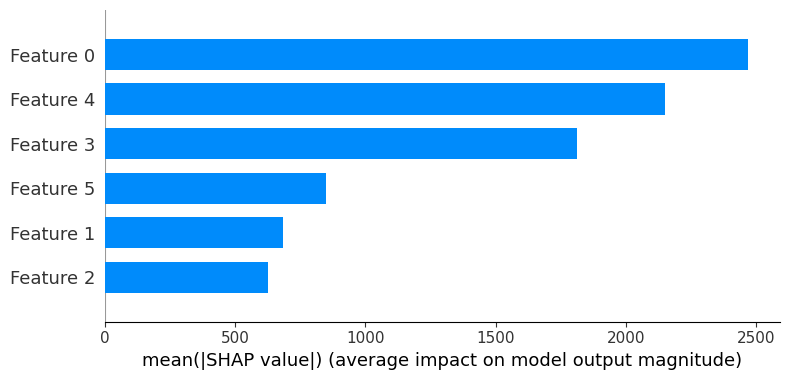

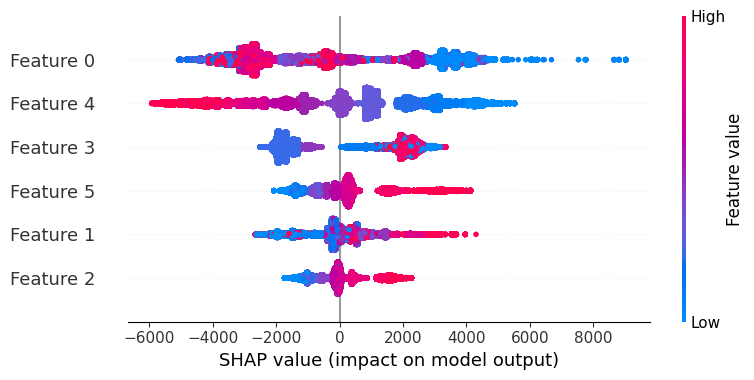

In [ ]:
import shap

# the SHAP explainer for the RF model
explainer_rf = shap.Explainer(best_model, X_train_selected)

# compute SHAP values for the entire dataset
shap_values_rf = explainer_rf.shap_values(X_train_selected)

# visualize global explanations using summary plots
shap.summary_plot(shap_values_rf, X_train_selected, plot_type="bar")
shap.summary_plot(shap_values_rf, X_train_selected)

# visualize local explanations using force plots
index = 5
shap.force_plot(explainer_rf.expected_value, shap_values_rf[index], pd.DataFrame(X_train_selected).iloc[index, :])


100%|===================| 239143/239477 [06:35<00:00]       

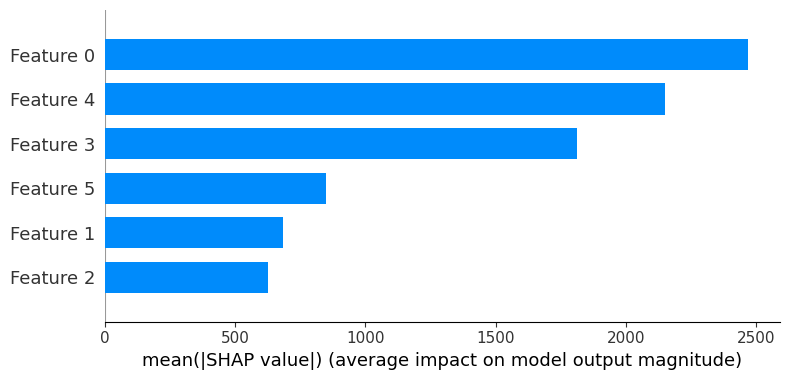

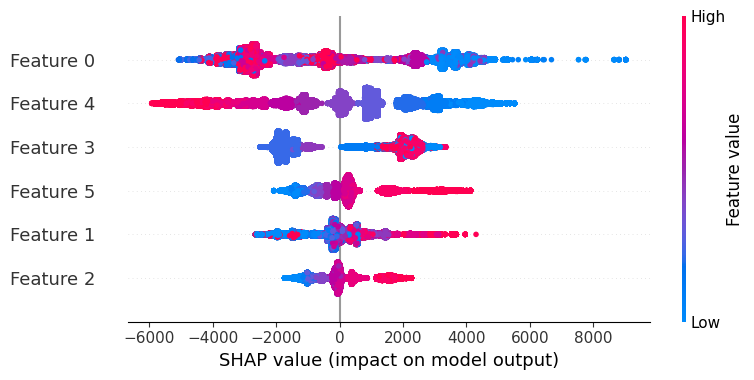

In [ ]:
# SHAP explainer for the Gradient Boosting model
explainer_gb = shap.Explainer(best_model, X_train_selected)

# SHAP values for the entire dataset
shap_values_gb = explainer_gb.shap_values(X_train_selected)

# visualize global explanations using summary plots
shap.summary_plot(shap_values_gb, X_train_selected, plot_type="bar")
shap.summary_plot(shap_values_gb, X_train_selected)

# visualize local explanations using force plots
index = 5
shap.force_plot(explainer_gb.expected_value, shap_values_gb[index], pd.DataFrame(X_train_selected).iloc[index, :])

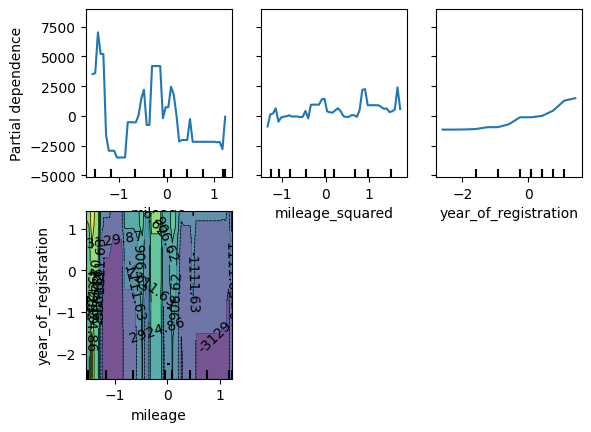

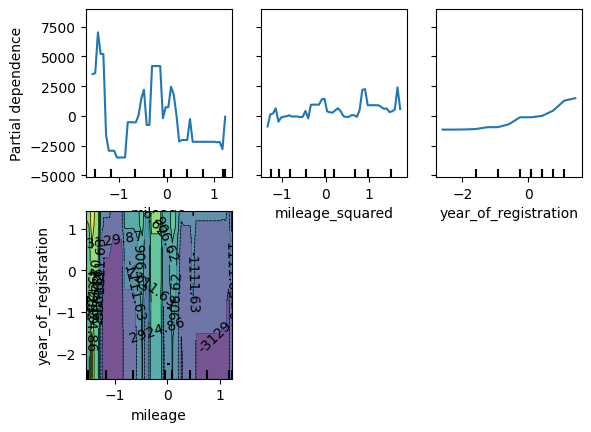

In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

feature_names = ['mileage', 'mileage_squared', 'year_of_registration', ('mileage', 'year_of_registration')]

# plot partial dependency
for name, model in models.items():
    if name == 'Linear Regression':
        continue

    # plot partial dependency for the current model
    PartialDependenceDisplay.from_estimator(best_model, X=X_train_selected, features=feature_names,
                            feature_names=feature_names, grid_resolution=50)
    # plt.title(f'Partial Dependency Plot - {name}')
    plt.show()

In [ ]:
# Prepare the new data
new_data_parameters = {
    'public_reference': 123456789,
    'mileage': 50575,
    'reg_code': '435',
    'standard_colour': 'Red',
    'standard_make': 'Toyota',
    'standard_model': 'Corolla',
    'vehicle_condition': 'USED',
    'year_of_registration': 2018,
    'body_type': 'Hatchback',
    'crossover_car_and_van': False,
    'fuel_type': 'Petrol'
}

In [ ]:
def preprocess_new_data(new_data_parameters):
    new_data = pd.DataFrame([new_data_parameters])
    new_data = new_data.drop(columns=['public_reference'])
    new_data['crossover_car_and_van'] = new_data['crossover_car_and_van'].astype(int)
    current_year = 2024
    new_data['car_age'] = current_year - new_data['year_of_registration']
    new_data['avg_annual_mileage'] = new_data['mileage'] / new_data['car_age']
    new_data['mileage_squared'] = new_data['mileage'] ** 2
    new_data['year_of_registration_squared'] = new_data['year_of_registration'] ** 2
    new_data['mileage_year_interaction'] = new_data['mileage'] * new_data['year_of_registration']

    new_data['standard_colour'] = label.fit_transform(new_data['standard_colour'])
    new_data['standard_make'] = label.fit_transform(new_data['standard_make'])
    new_data['standard_model'] = label.fit_transform(new_data['standard_model'])
    new_data['vehicle_condition'] = label.fit_transform(new_data['vehicle_condition'])
    new_data['body_type'] = label.fit_transform(new_data['body_type'])
    new_data['fuel_type'] = label.fit_transform(new_data['fuel_type'])

    new_data_scaled = scaler.transform(new_data)
    new_data_selected = selector.transform(new_data_scaled)
    return new_data_selected

preprocessed_new_data = preprocess_new_data(new_data_parameters)

In [ ]:
# Predict the price using the best model
predicted_price = best_model.predict(preprocessed_new_data)

print("Predicted price for car_1:", predicted_price)

Predicted price for car_1: [19041.00841215]
